In [1]:
import pandas as pd
import seaborn as sns
from pathlib import Path
from scipy.stats import t
import numpy as np

In [21]:
# Load the data
output_path = Path('../outputs/results_final')
output_path.mkdir(exist_ok=True)
data_gwlarge = pd.read_csv('../outputs/large_hallway_final/results.csv')
data_gwlarge.loc[data_gwlarge['env'] == 'Hallway', 'env'] = 'Avoid L'
data_gwlarge.loc[data_gwlarge['env'] == 'ContHallway', 'env'] = 'SoftAvoid L'
data_gwlarge.fillna(0, inplace=True)

data_gwsmall = pd.read_csv('../outputs/small_hallway_final/results.csv')
data_gwsmall = data_gwsmall[data_gwsmall.agent.str.contains('Rollout') | data_gwsmall.agent.str.contains('LP')]
data_gwsmall.loc[data_gwsmall['env'] == 'Hallway', 'env'] = 'Avoid S'
data_gwsmall.loc[data_gwsmall['env'] == 'ContHallway', 'env'] = 'SoftAvoid S'
data_gwsmall.fillna(0, inplace=True)

data_manhattan = pd.read_csv('../outputs/manhattan_final/results.csv')
data_manhattan = data_manhattan[data_manhattan.agent.str.contains('Rollout') | data_manhattan.agent.str.contains('LP')]

data = pd.concat([data_gwlarge, data_gwsmall, data_manhattan])
# data = pd.concat([data_gwsmall, data_manhattan])
data.agent[data.agent == 'RolloutRAMCP'] = 'RAMCP'
data.agent[data.agent == 'RolloutParetoUCT'] = 'T-UCT (ours)'
data.agent[data.agent == 'RolloutDualUCT'] = 'CC-POMCP'

data['algorithm'] = data.agent + '_t' + data.time_limit.astype(str)
data.loc[data.agent == 'LP', 'algorithm'] = 'LP'
data['benchmark'] = data.env + '_' + data.instance + '_sp' + data.slide_prob.astype(str) + '_tp' + data.trap_prob.astype(str)

data['feasible'] = data.penalty_mean <= data.c

data['t'] = (data['penalty_mean'] - data['c']) * np.sqrt(data['repetitions']) / data['penalty_std']

const_thresholds = data.groupby('env').c.max()
data = data.merge(const_thresholds, on='env', suffixes=('', '_max'))

data['t@05a'] = (data['penalty_mean'] - data['c'] - 0.05) * np.sqrt(data['repetitions']) / data['penalty_std']
data.loc[data['agent'] == 'LP', 't'] = 0
data['feasible_low'] = data['t'] <= t(df=data['repetitions']-1).ppf(0.95)
data['feasible_high'] = data['t'] <= t(df=data['repetitions']-1).ppf(0.05)
data['feasible@05a'] = data['t@05a'] <= t(df=data['repetitions']-1).ppf(0.05)
data.loc[data.agent == 'LP', 'feasible_low'] = True
data.loc[data.agent == 'LP', 'feasible_high'] = True
data.loc[data.agent == 'LP', 'feasible@05a'] = True
data.loc[data.agent == 'LP', 'feasible@10m'] = True

data.head()

max_rewards = data.groupby(['benchmark']).reward_mean.max()
extended_data = data.merge(max_rewards, on='benchmark', suffixes=('', '_max'))
order = ['Avoid S', 'SoftAvoid S', 'Avoid L', 'SoftAvoid L', 'Manhattan', -1, 5, 10, 20, 25, 50, 100, 200, 500, 'T-UCT (ours)', 'CC-POMCP', 'RAMCP', 'LP']
extended_data.sort_values(by=['env', 'time_limit', 'agent'], inplace=True, key=lambda x: x.apply(order.index))
extended_data.head()

/tmp/ipykernel_2507615/878644427.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.agent[data.agent == 'RolloutRAMCP'] = 'RAMCP'
/tmp/ipykernel_2507615/878644427.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.agent[data.agent == 'RolloutParetoUCT'] = 'T-UCT (ours)'
/tmp/ipykernel_2507615/878644427.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.agent[data.agent == 'RolloutDualUCT'] = 'CC-POMCP'
/tmp/ipykern

,agent,time_limit,c,env,instance,trap_prob,slide_prob,reward_mean,reward_std,penalty_mean,...,benchmark,feasible,t,c_max,t@05a,feasible_low,feasible_high,feasible@05a,feasible@10m,reward_mean_max
6912,LP,-1,0.00,Avoid S,map1-a=0-b=0.1-e=0.5-w=0.2,0.2,0.0,4.721173,0.0,0.0,...,Avoid S_map1-a=0-b=0.1-e=0.5-w=0.2_sp0.0_tp0.2,True,0.0,0.35,-inf,True,True,True,True,5.000000
6913,LP,-1,0.15,Avoid S,map1-a=0-b=0.1-e=0.5-w=0.2,0.2,0.0,4.721173,0.0,0.0,...,Avoid S_map1-a=0-b=0.1-e=0.5-w=0.2_sp0.0_tp0.2,True,0.0,0.35,-inf,True,True,True,True,5.000000
6914,LP,-1,0.35,Avoid S,map1-a=0-b=0.1-e=0.5-w=0.2,0.2,0.0,4.721173,0.0,0.0,...,Avoid S_map1-a=0-b=0.1-e=0.5-w=0.2_sp0.0_tp0.2,True,0.0,0.35,-inf,True,True,True,True,5.000000
6942,LP,-1,0.00,Avoid S,map2-a=0-b=0.1-e=0.5-w=0.2,0.2,0.0,0.970299,0.0,0.0,...,Avoid S_map2-a=0-b=0.1-e=0.5-w=0.2_sp0.0_tp0.2,True,0.0,0.35,-inf,True,True,True,True,2.103322
6943,LP,-1,0.15,Avoid S,map2-a=0-b=0.1-e=0.5-w=0.2,0.2,0.0,1.422682,0.0,0.0,...,Avoid S_map2-a=0-b=0.1-e=0.5-w=0.2_sp0.0_tp0.2,True,0.0,0.35,-inf,True,True,True,True,2.103322


In [22]:
# print columns
# extended_data.groupby(['env', 'time_limit', 'agent']).simulations_mean.mean()

### Tables

In [23]:
# import warnings
# warnings.filterwarnings("ignore")

# # minimum of reward_mean and reward_mean_real
# def get_table(data):
#     if 'reward_mean_real' in data.columns:
#         data['min_reward_mean'] = data[['reward_mean', 'reward_mean_real']].min(axis=1)
#     else:
#         data['min_reward_mean'] = data['reward_mean']
#     data['cvm'] = data['feasible'] * data['min_reward_mean']
#     data['cvl'] = data['feasible_low'] * data['min_reward_mean']
#     data['cvh'] = data['feasible_high'] * data['min_reward_mean']

#     for m in ['cvm', 'cvl', 'cvh']:
#         data[m] /= data.groupby('algorithm')[m].mean().max()

#     data['cvmn'] = data['feasible'] * data['min_reward_mean'] / (data['reward_mean_real'])
#     data['cvln'] = data['feasible_low'] * data['min_reward_mean'] / (data['reward_mean_real'])
#     data['cvhn'] = data['feasible_high'] * data['min_reward_mean'] / (data['reward_mean_real'])

#     return data.groupby(['algorithm'])[[
#         'feasible_low', 'feasible', 'feasible_high',
#         'cvl', 'cvm', 'cvh',
#         'cvln', 'cvmn', 'cvhn',
#     ]].mean().sort_values(by='feasible', ascending=False)

# tables = {
#     'table.csv': get_table(extended_data),
# }
# for env in extended_data.env.unique():
#     tables[f'table_{env}.csv'] = get_table(extended_data.loc[extended_data.env == env])

# for name, table in tables.items():
#     table.to_csv(output_path / name)
#     print('\n', name, '\n', table)


# warnings.filterwarnings("default")


### STD Table

In [24]:
data = extended_data[['env', 'agent', 'penalty_std', 'penalty_mean', 'feasible_low', 'repetitions', 'feasible', 'c']]
data = data[(data.c != 0) & (data.feasible_low)]
data = data[data.agent != 'LP']

data = data[data['c'] < data['penalty_mean']]
data['overhead'] = (data['penalty_mean'] - data['c']) / data['c']

# data['overhead'] = np.maximum(data['overhead'], 0)
# overhead_table = data.groupby(['env', 'agent'])['overhead'].aggregate(['mean', 'max'])
overhead_table = data.groupby(['env', 'agent']).overhead.aggregate(['mean', 'max'])



# data['sample_std'] = data['penalty_std'] / np.sqrt(data['repetitions']-1) / data['c']
# std_table = data.groupby(['env', 'agent'])['sample_std'].aggregate(['mean', 'max'])
# std_table = std_table.reset_index()
# std_table

overhead_table




mean       max
env         agent                           
Avoid L     CC-POMCP      0.054815  0.111111
            RAMCP         0.098124  0.244444
            T-UCT (ours)  0.094931  0.244444
Avoid S     CC-POMCP      0.110775  0.244444
            RAMCP         0.085778  0.244444
            T-UCT (ours)  0.090077  0.244444
Manhattan   CC-POMCP      0.011317  0.031111
            RAMCP         0.017704  0.066667
            T-UCT (ours)  0.021377  0.053333
SoftAvoid L RAMCP         0.005394  0.026667
            T-UCT (ours)  0.013546  0.053333
SoftAvoid S CC-POMCP      0.055556  0.151111
            RAMCP         0.030308  0.182222
            T-UCT (ours)  0.032232  0.155556

### Plots

Barplot with "weak" feasibility

/tmp/ipykernel_2507615/3133502088.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b['variable'] = 'Conditional Value'
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No ar

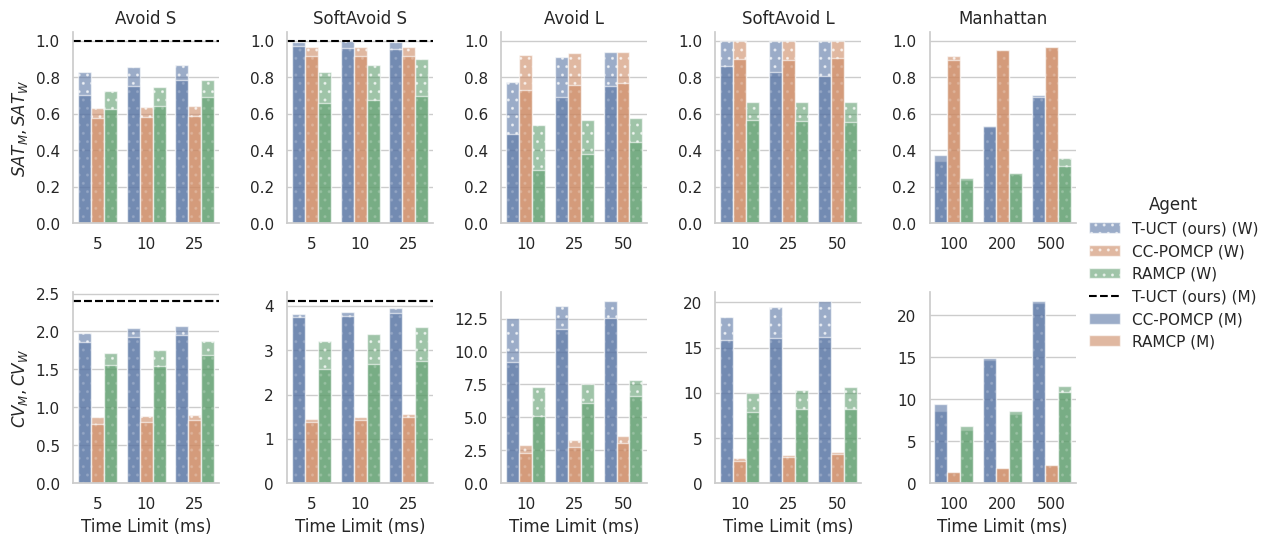

In [26]:
# Barplot of the results in `table.csv`
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product


g = None
ld = {}

# for key, label in [('feasible_low', 'Weak Feasibility'), ('feasible', 'Mean Feasibility'), ('feasible_high', 'Strong Feasibility'), ('feasible@05a', 'Feasibility at 0.05'), ('feasible@10m', 'Feasibility at 10%')]:
for key, label in [('feasible@05a', '$SAT$'), ('feasible', '$SAT$')]:#, ('feasible@10m', '$SAT$')]:
# for key, label in [('feasible_high', 'Strong Feasibility'), ('feasible@05a', 'Feasibility at 0.05')]:

    # plot_data = extended_data.sort_values(by=['env', 'time_limit'], ascending=[True, True])
    plot_data = extended_data.copy()
    # plot_data['min_reward_mean'] = plot_data[['reward_mean', 'reward_mean_real']].min(axis=1)
    plot_data['env_time'] = plot_data['env'] + ' ' + plot_data['time_limit'].astype(str) + 'ms'
    plot_data['value'] = plot_data[key] * plot_data['reward_mean'] #/ plot_data['reward_mean_max']

    # groups = plot_data.groupby(['time_limit', 'agent', 'env'])[['feasible', 'feasible@10m']].mean()
    # print(groups[groups['feasible'] < groups['feasible@10m']])

    # plot_data['value_f'] = plot_data['feasible'] * plot_data['min_reward_mean']
    # plot_data['value_f@10m'] = plot_data['feasible@10m'] * plot_data['min_reward_mean']
    # groups = plot_data.groupby(['time_limit', 'agent', 'env'])[['value_f', 'value_f@10m']].mean()
    # groups['rel_error'] = (groups['value_f@10m'] - groups['value_f']) / groups['value_f']

    
    # max_vals = pd.DataFrame([['Avoid S', 4.0], ['Avoid L', 21.0], ['SoftAvoid S', 4.0], ['SoftAvoid L', 20.0], ['Manhattan', 4.0]], columns=['env', 'value']).set_index('env')
    # # print(groups.env)
    # # break
    # groups['abs_error'] = (groups['value_f@10m'] - groups['value_f']) / max_vals.value
    # print(groups[groups['value_f'] < groups['value_f@10m']])


    lp_val = plot_data.loc[plot_data.agent == 'LP'].groupby('env').value.mean()
    # print(lp_val)

    plot_data = plot_data[plot_data.agent != 'LP']

    # melt the data for seaborn


    a = plot_data[['env', 'time_limit', 'agent', key]].rename(columns={key: 'value'})
    a['variable'] = label
    b = plot_data[['env', 'time_limit', 'agent', 'value']]
    b['variable'] = 'Conditional Value'
    plot_data = pd.concat([a, b])

    sns.set_theme(style="whitegrid")

    col_num = len(plot_data.env.unique())
    row_num = len(plot_data.variable.unique())

    if g is None:
        g = sns.FacetGrid(plot_data, col="env", row="variable", height=2.7, aspect=0.8, sharex=False, sharey=False, col_order=['Avoid S', 'Avoid L', 'SoftAvoid S', 'SoftAvoid L', 'Manhattan'])
    for i, (ax, (var, env)) in enumerate(zip(g.axes.flat, product(plot_data.variable.unique(), plot_data.env.unique()))):
        use_legend = i == 0
        alpha = 1
        if key == 'feasible':
            alpha = 0.6
            # sns.set_palette(sns.color_palette("deep", as_cmap=False))
        else:
            alpha = 0.6
            # sns.set_palette(sns.color_palette("rocket", as_cmap=False))
        o = sns.barplot(x='time_limit', y='value', hue='agent', data=plot_data.loc[(plot_data.env == env) & (plot_data.variable == var)], errorbar=None, ax=ax, alpha=alpha, legend=use_legend)
        if key != 'feasible':
            for i, bar in enumerate(ax.patches):
                bar.set_hatch('..')
                # if i % 2:
                #     bar.set_hatch('\\')
                # else:
                #     bar.set_hatch('//')
        # print(ax.legend().get_legend_handler_map())
        if i == 0:
            ax.set_ylabel('$SAT_M, SAT_W$')
        elif i == col_num:
            ax.set_ylabel('$CV_M, CV_W$')
        if i < col_num:
            ax.set_title(env)
            ax.set_xlabel('')
            ax.set_ylim(0, 1.05)
            if i > 0:
                # ax.set_yticklabels([])
                ax.set_ylabel('')
            if env in lp_val.index.unique():
                ax.axhline(y=1, color='black', linestyle='--', label='LP')
        else:
            ax.set_xlabel('Time Limit (ms)')
            ax.set_title('')
            if env in lp_val.index.unique():
                ax.axhline(y=lp_val[env], color='black', linestyle='--', label='LP')
            if i > col_num:
                # ax.set_yticklabels([])
                ax.set_ylabel('')
        if use_legend:
            handles, labels = ax.get_legend_handles_labels()
            if key != 'feasible':
                lp_index = labels.index('LP')
                labels = [label + ' (W)' for label in labels if label != 'LP']
                handles.pop(lp_index)
            else:
                labels = [label + ' (M)' if label != 'LP' else 'LP' for label in labels]
            ld.update(dict(zip(labels, handles)))
        ax.legend().remove()
# set the grid legend
g.add_legend(title='Agent', loc='right', legend_data=ld)
# g.add_legend(title='Agent', loc='right')

plt.savefig(output_path / f'join_barplot.pdf', bbox_inches="tight")

